<a href="https://colab.research.google.com/github/NandavardhanRadhakrishnan/Class-incremental-learning/blob/main/NetworkOfModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
def create_mnist_data(class_splits, split_index, csv_file="mnist.csv", image_shape=(1, 28, 28)):
    """
    Creates MNIST dataset for a specific split.
    """
    df = pd.read_csv(csv_file)
    all_classes = sorted(df['label'].unique())

    start_class = sum(class_splits[:split_index])
    end_class = start_class + class_splits[split_index]
    valid_classes = all_classes[start_class:end_class]

    filtered_df = df[df['label'].isin(valid_classes)]

    X = filtered_df.drop(columns=['label']).values
    y = filtered_df['label'].values

    label_mapping = {cls: i for i, cls in enumerate(valid_classes)}
    y = np.array([label_mapping[label] for label in y])

    X = torch.tensor(X / 255.0, dtype=torch.float32)
    X = X.view(-1, *image_shape)
    y = torch.tensor(y, dtype=torch.long)

    return TensorDataset(X, y)



In [4]:
def create_group_data(class_splits, csv_file="mnist.csv", image_shape=(1, 28, 28)):
    """
    Creates MNIST dataset for the grouping model (e.g., maps different splits to groups).
    """
    df = pd.read_csv(csv_file)

    def relabel_digit(digit):
        for i, split in enumerate(class_splits):
            if digit < sum(class_splits[:i + 1]):
                return i
        return len(class_splits) - 1

    df['label'] = df['label'].apply(relabel_digit)

    X = df.drop(columns=['label']).values
    y = df['label'].values

    X = torch.tensor(X / 255.0, dtype=torch.float32)
    X = X.view(-1, *image_shape)
    y = torch.tensor(y, dtype=torch.long)

    return TensorDataset(X, y)



In [5]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2, 2)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x



In [6]:
def train_model(model, data_loader, criterion, optimizer, epochs, device):
    """
    Trains a given model.
    """
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        with tqdm(total=len(data_loader), desc=f"Epoch {epoch + 1}/{epochs}", unit="batch") as pbar:
            for X_batch, y_batch in data_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                pbar.set_postfix(loss=total_loss / (pbar.n + 1))
                pbar.update(1)



In [7]:
def inference_with_grouping(models, model_group, combined_loader, class_splits, index=None):
    """
    Performs inference using multiple models based on a grouping model.
    """
    all_preds = []
    all_labels = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model_group.eval()
    for model in models:
        model.eval()

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(combined_loader):
            images, labels = images.to(device), labels.to(device)

            if len(images.shape) == 3:
                images = images.unsqueeze(1)

            # If index is provided, infer only that index
            if index is not None:
                images = images[index].unsqueeze(0)
                labels = labels[index].unsqueeze(0)

            # Determine which model to use
            group_logits = model_group(images)
            group_pred = torch.argmax(group_logits, dim=1)

            final_preds = []
            for i in range(images.shape[0]):
                model_idx = group_pred[i].item()
                model = models[model_idx]
                logits = model(images[i].unsqueeze(0))
                pred = torch.argmax(logits, dim=1).item()

                # Offset to match global label space
                offset = sum(class_splits[:model_idx])
                final_preds.append(pred + offset)

            all_preds.extend(final_preds)
            all_labels.extend(labels.cpu().numpy())

            if batch_idx % 2000 == 0 or index is not None:
                print(f"Batch {batch_idx} Predictions:")
                print(f"Predicted: {final_preds}")
                print(f"True:      {labels.cpu().numpy()}")

            if index is not None:
                break

    # Compute accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"\nOverall Accuracy: {accuracy * 100:.2f}%")

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=list(range(sum(class_splits))))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=list(range(sum(class_splits))),
                yticklabels=list(range(sum(class_splits))))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
    print(cm)



Using device: cpu

Creating dataset for split 0 with 3 classes...
Training model 0 for 3 classes...


Epoch 3/3: 100%|██████████| 204/204 [00:15<00:00, 12.89batch/s, loss=0.0114]


Model 0 training completed.

Creating dataset for split 1 with 3 classes...
Training model 1 for 3 classes...


Epoch 3/3: 100%|██████████| 191/191 [00:14<00:00, 13.10batch/s, loss=0.0134]


Model 1 training completed.

Creating dataset for split 2 with 4 classes...
Training model 2 for 4 classes...


Epoch 3/3: 100%|██████████| 263/263 [00:20<00:00, 12.89batch/s, loss=0.0256]


Model 2 training completed.

Creating and training group classifier model...


Epoch 3/3: 100%|██████████| 657/657 [00:54<00:00, 12.10batch/s, loss=0.0356]


Group classifier model training completed.

Creating combined dataset for inference...
Starting inference using grouped models...

Batch 0 Predictions:
Predicted: [1, 0, 1, 4, 0, 0, 7, 3, 5, 3, 8, 9, 1, 3, 3, 1, 2, 0, 7, 6, 8, 6, 2, 0, 2, 3, 6, 9, 9, 7, 8, 9, 4, 9, 2, 1, 3, 1, 1, 4, 9, 1, 4, 4, 2, 6, 3, 7, 7, 4, 7, 5, 1, 9, 0, 2, 2, 3, 9, 1, 1, 1, 5, 0]
True:      [1 0 1 4 0 0 7 3 5 3 8 9 1 3 3 1 2 0 7 5 8 6 2 0 2 3 6 9 9 7 8 9 4 9 2 1 3
 1 1 4 9 1 4 4 2 6 3 7 7 4 7 5 1 9 0 2 2 3 9 1 1 1 5 0]

Overall Accuracy: 98.66%


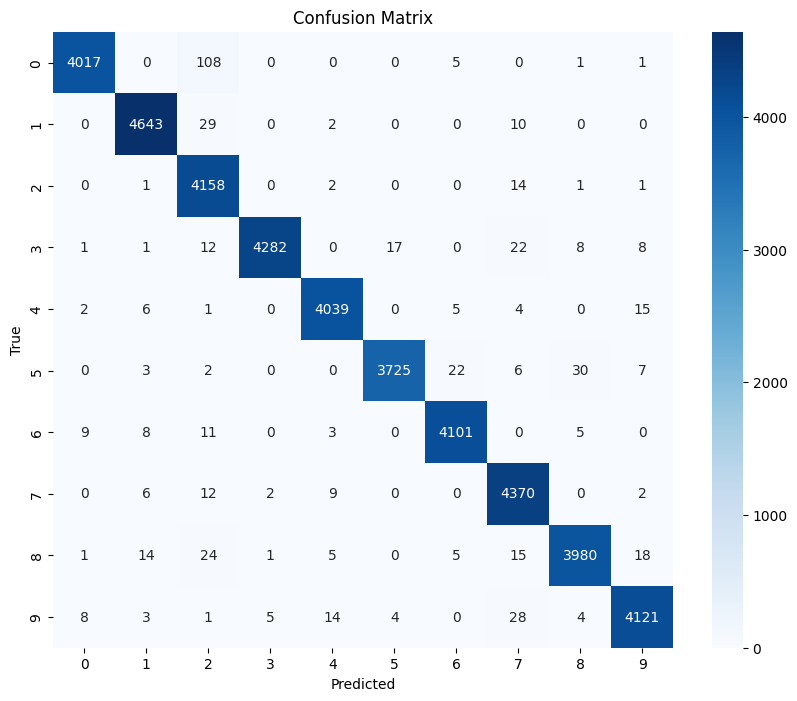

[[4017    0  108    0    0    0    5    0    1    1]
 [   0 4643   29    0    2    0    0   10    0    0]
 [   0    1 4158    0    2    0    0   14    1    1]
 [   1    1   12 4282    0   17    0   22    8    8]
 [   2    6    1    0 4039    0    5    4    0   15]
 [   0    3    2    0    0 3725   22    6   30    7]
 [   9    8   11    0    3    0 4101    0    5    0]
 [   0    6   12    2    9    0    0 4370    0    2]
 [   1   14   24    1    5    0    5   15 3980   18]
 [   8    3    1    5   14    4    0   28    4 4121]]
Inference completed.


In [9]:
# ---- Main Script ----
class_splits = [3,3,4]  # Example class split
image_shape = (1, 28, 28)
batch_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\n")

# Create datasets and models
models = []
data_loaders = []
for i, num_classes in enumerate(class_splits):
    print(f"Creating dataset for split {i} with {num_classes} classes...")
    dataset = create_mnist_data(class_splits, i, image_shape=image_shape)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    data_loaders.append(loader)

    print(f"Training model {i} for {num_classes} classes...")
    model = SimpleCNN(num_classes).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    train_model(model, loader, criterion, optimizer, epochs=3, device=device)

    models.append(model)
    print(f"Model {i} training completed.\n")

# Create and train grouping model
print("Creating and training group classifier model...")
group_data = create_group_data(class_splits, image_shape=image_shape)
group_loader = DataLoader(group_data, batch_size=batch_size, shuffle=True)

model_group = SimpleCNN(len(class_splits)).to(device)
optimizer_group = optim.Adam(model_group.parameters(), lr=0.001)
criterion_group = nn.CrossEntropyLoss()
train_model(model_group, group_loader, criterion_group, optimizer_group, epochs=3, device=device)
print("Group classifier model training completed.\n")

# Perform inference
print("Creating combined dataset for inference...")
combined_data = create_mnist_data([sum(class_splits)], 0, image_shape=image_shape)
combined_loader = DataLoader(combined_data, batch_size=batch_size, shuffle=False)

print("Starting inference using grouped models...\n")
inference_with_grouping(models, model_group, combined_loader, class_splits)
print("Inference completed.")
